In [1]:
import pandas as pd
import os
import re
import numpy as np

In [2]:
exp = 'camelyon_noise0.0_randaug1_cnn'
dir = f'experiment/{exp}'
plot_dir = f'figures'
os.makedirs(plot_dir, exist_ok=True)
namelist = os.listdir(dir)
small_width = 1
mid_width = 11
large_width = 64
epoch = 100

In [3]:
import re

def get_complexity(name):
    return int(re.search(r'((width)|(complexity))(.+?)_', name).group(4))

In [4]:


sample_train = pd.DataFrame(columns=['acc_wg_train', 
                                    'acc_avg_train', 
                                    'epoch', 
                                    'width'])
sample_test = pd.DataFrame(columns=['acc_wg_idval', 
                                    'acc_avg_idval',
                                    'acc_wg_val', 
                                    'acc_avg_val',
                                    'acc_wg_test', 
                                    'acc_avg_test',
                                    'epoch', 
                                    'width'])

for name in namelist:
    # width = (int(name.split('_')[1][5:]))
    width = get_complexity(name)
    sample = pd.read_csv(os.path.join(dir,name,'version_0','metrics.csv'))
    sample_trainlossa = []
    sample_trainacca= []
    sample_testloss = []
    sample_testacc = []
    sample_train_epoch = sample[['acc_wg_train', 
                                'acc_avg_train', 
                                'epoch']].dropna(axis=0, how='any').groupby('epoch').agg('mean')
    sample_train_epoch['epoch'] = sample_train_epoch.index
    sample_test_epoch = sample[['acc_wg_idval', 
                                'acc_avg_idval',
                                'acc_wg_val', 
                                'acc_avg_val',
                                'acc_wg_test', 
                                'acc_avg_test',
                                'epoch', ]].dropna(axis=0, how='any')
    sample_train_epoch['width'] = width
    sample_test_epoch['width'] = width
    sample_train = pd.concat([sample_train, sample_train_epoch])
    sample_test = pd.concat([sample_test, sample_test_epoch])

    sample_train = sample_train[sample_train['epoch'] < epoch]
    sample_test = sample_test[sample_test['epoch'] < epoch]
    

In [5]:
sample_test.reset_index(drop=True, inplace=True)
sample_train.reset_index(drop=True, inplace=True)

In [6]:
def get_final(pds):
    return pds.iloc[-1]

sample_train_width = sample_train.groupby('width').apply(get_final).drop(['epoch'], axis=1)
sample_test_width = sample_test.groupby('width').apply(get_final).drop(['epoch'], axis=1)

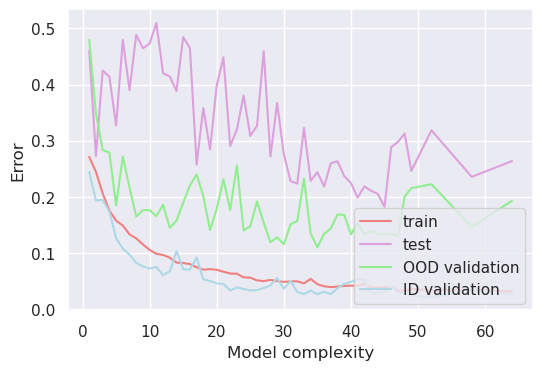

In [7]:
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d as gf1
from scipy.signal import savgol_filter as sf
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(sample_train_width['width'], gf1(1-sample_train_width['acc_wg_train'], sigma=0.5), label='train', color='lightcoral')
plt.plot(sample_test_width['width'], gf1(1-sample_test_width['acc_wg_test'], sigma=0.5), label='test',color='plum')
plt.plot(sample_test_width['width'], gf1(1-sample_test_width['acc_wg_val'], sigma=0.5), label='OOD validation',color='lightgreen')
plt.plot(sample_test_width['width'], gf1(1-sample_test_width['acc_wg_idval'], sigma=0.5), label='ID validation',color='lightblue')
plt.xlabel('Model complexity')
plt.ylabel('Error')
plt.legend(loc='lower right')
plt.savefig(os.path.join(plot_dir,f'{exp}_Worst Group Error on Camelyon17 Dataset.png'))
plt.show()

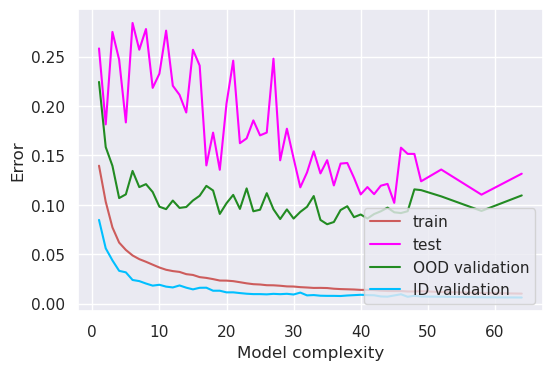

In [8]:
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d as gf1
from scipy.signal import savgol_filter as sf

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(sample_train_width['width'], gf1(1-sample_train_width['acc_avg_train'], sigma=.5), label='train', color='indianred')
plt.plot(sample_test_width['width'], gf1(1-sample_test_width['acc_avg_test'], sigma=.5), label='test',color='magenta')
plt.plot(sample_test_width['width'], gf1(1-sample_test_width['acc_avg_val'], sigma=.5), label='OOD validation',color='forestgreen')
plt.plot(sample_test_width['width'], gf1(1-sample_test_width['acc_avg_idval'], sigma=.5), label='ID validation',color='deepskyblue')
plt.xlabel('Model complexity')
plt.ylabel('Error')
plt.legend(loc='lower right')
plt.savefig(os.path.join(plot_dir,f'{exp}_Average Error on Camelyon17 Dataset.png'))
plt.show()

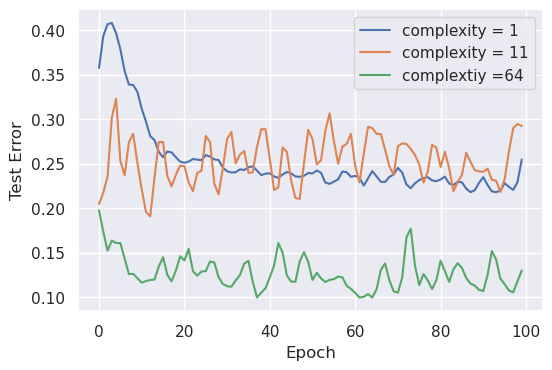

In [9]:
small = sample_test.groupby('width').get_group(small_width)
mid = sample_test.groupby('width').get_group(mid_width)
large = sample_test.groupby('width').get_group(large_width)

plt.figure(figsize=(6, 4), dpi=100)
# plt.plot(np.log10(np.array(small['epoch']).astype('int')+1), gf1(1-small['acc_avg_test'], sigma=1), label='width = 1')
plt.plot(small['epoch'], gf1(1-small['acc_avg_test'], sigma=.8), label=f'complexity = {small_width}')
# plt.plot(small['epoch'], 1-small['acc_avg_test'], label=f'complexity = {small_width}')
# plt.plot(np.log10(np.array(mid['epoch']).astype('int')+1), gf1(1-mid['acc_avg_test'],sigma=1), label='width = 5')
plt.plot(mid['epoch'], gf1(1-mid['acc_avg_test'], sigma=.8), label=f'complexity = {mid_width}')
# plt.plot(mid['epoch'], 1-mid['acc_avg_test'], label=f'complexity = {mid_width}')
# plt.plot(np.log10(np.array(large['epoch']).astype('int')+1), gf1(1-large['acc_avg_test'],sigma=1), label='width = 32')
plt.plot(large['epoch'], gf1(1-large['acc_avg_test'], sigma=.8), label=f'complextiy ={large_width}')
# plt.plot(large['epoch'], 1-large['acc_avg_test'], label=f'complextiy ={large_width}')
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend()
plt.savefig(os.path.join(plot_dir,f'{exp}_Epoch-wised Model Test Error.png'))
plt.show()

In [10]:
width = []
for name in namelist:
    width += [get_complexity(name)]
width = np.array(width)
error = []
for wid in width:
    error.append(np.array(1-sample_test.groupby('width').get_group(wid)['acc_avg_test']))

error = np.array(error)

widthn = np.sort(width)
errorn = error[np.argsort(width)]

In [11]:
width = []
for name in namelist:
    width += [get_complexity(name)]
width = np.array(width)
error = []
for wid in width:
    error.append(np.array(1-sample_test.groupby('width').get_group(wid)['acc_avg_val']))

error = np.array(error)

widthn = np.sort(width)
error_val = error[np.argsort(width)]

In [12]:
width = []
for name in namelist:
    width += [get_complexity(name)]
width = np.array(width)
error = []
for wid in width:
    error.append(np.array(1-sample_test.groupby('width').get_group(wid)['acc_avg_idval']))

error = np.array(error)

widthn = np.sort(width)
error_idval = error[np.argsort(width)]

/tmp/ipykernel_591491/2996335642.py:63: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(sm, cmap=cmap, ticks=ticks)


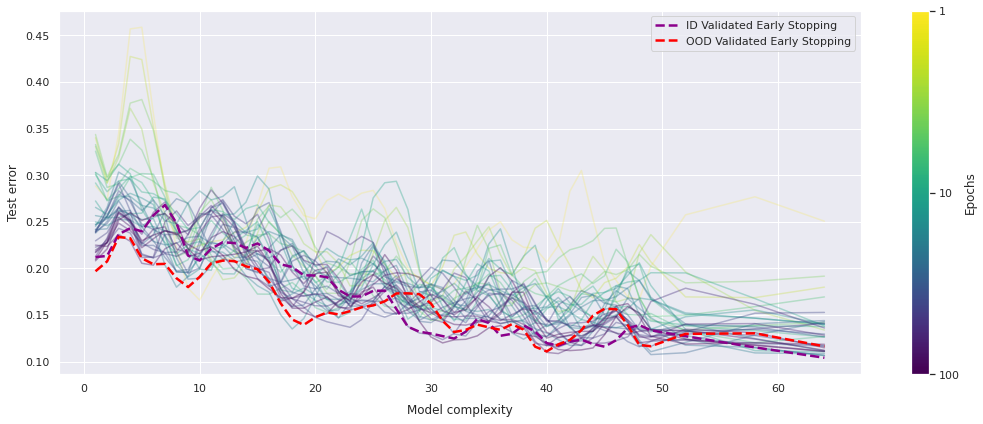

In [13]:
import matplotlib as mpl
import matplotlib

def rescale_cmap(name, rescale):
        cmap = plt.cm.get_cmap(name)
        colors = []
        for i in range(256):
            x = i/256
            colors += [cmap(rescale(x))]
        return matplotlib.colors.ListedColormap(colors)

def scale(maxIdx, i):
    return np.log(i) / np.log(maxIdx)

base = 1.1

maxIdx = errorn.shape[1]
idx = np.unique(np.array(base**np.arange(0, np.log(maxIdx)/np.log(base)), dtype=int) - 1)
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
    
    # cos: skews more colors to the middle of the range
    # x**a: skews more colors towards the beginning/end of the range for larger/smaller a
    # p cos(...) + q x: controls strength of rescaling
cmap = rescale_cmap('viridis', lambda x: 0.5 * (1 - np.cos(np.pi * x**0.7)) / 2 + 0.5 * x)

for j, i in enumerate(idx):
    #s = j / len(idx)
    s = scale(maxIdx+1, i+1)
    
    alpha=min(0.2*np.sqrt(s)+0.2, 1)
    if s == 1.0:
        alpha = 1.0
    # ax1.plot(widthn, errorn[:, i], linestyle='-', color=cmap(1.0-s), alpha=alpha)
    ax1.plot(widthn, gf1(errorn[:, i], sigma=1), linestyle='-', color=cmap(1.0-s), alpha=alpha)

# ax1.plot(widthn, sf(errorn.min(axis=1), 5, 2), linestyle='dashed', color='red', lw=2.5, label='Optimal Early Stopping')


min_idx = error_idval.argmin(axis=1)
# ax1.plot(widthn, errorn[np.arange(len(min_idx)),min_idx], linestyle='dashed', color='purple', lw=2.5, label='ID Validated Early Stopping')
ax1.plot(widthn, gf1(errorn[np.arange(len(min_idx)),min_idx],sigma=1), linestyle='dashed', color='darkmagenta', lw=2.5, label='ID Validated Early Stopping')

min_idx = error_val.argmin(axis=1)
# ax1.plot(widthn, errorn[np.arange(len(min_idx)),min_idx], linestyle='dashed', color='red', lw=2.5, label='OOD Validated Early Stopping')
ax1.plot(widthn, gf1(errorn[np.arange(len(min_idx)),min_idx],sigma=1), linestyle='dashed', color='red', lw=2.5, label='OOD Validated Early Stopping')
# ax1.plot(widthn, sf(errorn[np.arange(len(min_idx)),min_idx], 5, 2), linestyle='dashed', color='red', lw=2.5, label='OOD Validated Early Stopping')

ax1.set_ylabel('Test error')
ax1.set_xlabel('Model complexity')
ax1.xaxis.labelpad = 10
ax1.yaxis.labelpad = 5
#ax1.spines['top'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.legend()
plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

ticks = 1 - scale(maxIdx, [1, 10, 100, 1000])
#print(ticks)

cb = plt.colorbar(sm, cmap=cmap, ticks=ticks)
cb.ax.set_yticklabels(['1', '10', '100', '1000']) 
cb.set_label('Epochs')
fig.savefig(os.path.join(plot_dir,f'{exp}_Dynamic Plot of Model Test Error.png'))
